In [1]:
import pandas as pd
import ast
from datetime import datetime

def extract_waitlist_info(status_str):
    """
    Extracts the final waitlist number.
    - If the string contains a slash ("/"), assume it has two parts.
    - Use the second part that contains 'WL' if present.
    - If it contains "AVAILABLE", parse that number as negative.
    - Otherwise, try to extract digits from any part containing "WL".
    """
    # If the status contains a slash, split it.
    if '/' in status_str:
        parts = status_str.split('/')
        # Look for the part that starts with "WL"
        # If there are two WL parts, we use the second.
        wl_parts = [p for p in parts if "WL" in p]
        if len(wl_parts) >= 2:
            part = wl_parts[1]  # second WL value
        elif wl_parts:
            part = wl_parts[0]
        else:
            part = status_str
    else:
        part = status_str

    # Now handle AVAILABLE status
    if "AVAILABLE" in part.upper():
        # Example: "AVAILABLE-010"
        try:
            num_str = part.split('-')[-1]
            # Remove any leading zeros
            return -int(num_str.lstrip("0") or "0")
        except Exception as e:
            return None
    # Otherwise, if it contains WL, extract digits
    if "WL" in part.upper():
        num_str = ''.join(filter(str.isdigit, part))
        if num_str:
            return int(num_str)
    return None

def process_availability(avail_str):
    """
    Process the availability string and return a list of dictionaries.
    Each dictionary will have:
    - journeyDate (datetime)
    - dayOfWeek (e.g., "Monday")
    - waitlist (numeric, as per extract_waitlist_info)
    """
    try:
        avail_list = ast.literal_eval(avail_str)
    except Exception as e:
        return []
    
    processed = []
    for entry in avail_list:
        journey_date_str = entry.get('date')
        try:
            # Assuming format is "d-m-Y" e.g., "5-11-2023"
            journey_date = datetime.strptime(journey_date_str, "%d-%m-%Y")
        except Exception as e:
            journey_date = None
        day_of_week = journey_date.strftime("%A") if journey_date else None
        waitlist_num = extract_waitlist_info(entry.get('status', ''))
        processed.append({
            'journeyDate': journey_date,
            'dayOfWeek': day_of_week,
            'waitlist': waitlist_num
        })
    return processed

# Load CSV and parse timeStamp as datetime.
df = pd.read_csv("../Data/irctc/dynamic_coverage.csv", parse_dates=['timeStamp'])

# Process the availability column.
df['availability_parsed'] = df['availability'].apply(process_availability)

# Explode the availability_parsed column to get one row per availability record.
df_exploded = df.explode('availability_parsed')

# Expand the dictionary into separate columns.
df_exploded = pd.concat(
    [df_exploded.drop(columns=['availability_parsed']), 
     df_exploded['availability_parsed'].apply(pd.Series)],
    axis=1
)

# Calculate days remaining (journeyDate - timeStamp) in days.
# Ensure both columns are datetime.
df_exploded['daysRemaining'] = (df_exploded['journeyDate'] - df_exploded['timeStamp']).dt.days

# Display the resulting DataFrame columns of interest.
print(df_exploded[['trainNumber', 'journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining']])

# Optionally, save the processed data to a CSV.
df_exploded[['trainNumber', 'journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining']].to_csv("processed_availability.csv", index=False)


       trainNumber journeyDate dayOfWeek  waitlist  daysRemaining
0             1027  2023-11-05    Sunday      10.0              4
0             1027  2023-11-07   Tuesday      15.0              6
0             1027  2023-11-09  Thursday      26.0              8
0             1027  2023-11-11  Saturday      18.0             10
0             1027  2023-11-12    Sunday      10.0             11
...            ...         ...       ...       ...            ...
30587        22420  2024-01-09   Tuesday      -6.0             69
30587        22420  2024-01-11  Thursday      -6.0             71
30587        22420  2024-01-13  Saturday      -6.0             73
30587        22420  2024-01-14    Sunday      -5.0             74
30587        22420  2024-01-16   Tuesday      -6.0             76

[175350 rows x 5 columns]


In [2]:


# Assuming df_exploded is the DataFrame from the previous steps
# with columns: trainNumber, dayOfWeek, waitlist, etc.

# Group by 'trainNumber' and 'dayOfWeek' and calculate the mean waitlist value
mean_waitlist = df_exploded.groupby(['trainNumber', 'dayOfWeek'])['waitlist'].mean().reset_index()

# Optionally, sort the results for easier viewing:
mean_waitlist = mean_waitlist.sort_values(['trainNumber', 'dayOfWeek'])

print(mean_waitlist)

# Save the result to a CSV if desired:
mean_waitlist.to_csv("mean_waitlist_by_train_and_day.csv", index=False)


     trainNumber dayOfWeek   waitlist
0           1027    Friday  30.333333
1           1027    Monday  12.333333
2           1027  Saturday   0.125000
3           1027    Sunday   6.375000
4           1027  Thursday  -0.255319
..           ...       ...        ...
498        22404    Sunday -79.250000
499        22420  Saturday -21.179245
500        22420    Sunday -26.000000
501        22420  Thursday -21.019048
502        22420   Tuesday -26.321429

[503 rows x 3 columns]


In [15]:
import pandas as pd

# Assuming df_exploded is your processed DataFrame containing:
#   - 'trainNumber' (e.g., 1027, 22420, etc.)
#   - 'dayOfWeek' (e.g. "Monday", "Tuesday", etc.)
#   - 'classCode' (e.g. "2A", "3A", "2S")
#   - 'waitlist' (numeric)

# 1. Group by trainNumber, dayOfWeek, and classCode; then compute mean waitlist.
df_train_day_class = (
    df_exploded
    .groupby(['trainNumber', 'dayOfWeek', 'classCode'], as_index=False)['waitlist']
    .mean()
)

# 2. Sort dayOfWeek in a logical order (Monday -> Sunday) if desired.
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_train_day_class['dayOfWeek'] = pd.Categorical(df_train_day_class['dayOfWeek'], 
                                                 categories=days_order, 
                                                 ordered=True)
df_train_day_class = df_train_day_class.sort_values(['trainNumber', 'dayOfWeek', 'classCode'])

print(df_train_day_class)

# 3. (Optional) Pivot if you want dayOfWeek as rows and classCode as columns,
# but still keep trainNumber as part of the index.
df_pivoted = df_train_day_class.pivot(
    index=['trainNumber','dayOfWeek'], 
    columns='classCode', 
    values='waitlist'
)

print(df_pivoted)

# 4. Save to CSV if desired
df_train_day_class.to_csv("mean_waitlist_by_train_day_class.csv", index=False)
df_pivoted.to_csv("mean_waitlist_pivot_train_day_class.csv")

df_pivoted.head(10)


      trainNumber dayOfWeek classCode   waitlist
3            1027    Monday        2A   3.500000
4            1027    Monday        3A   6.500000
5            1027    Monday        SL  27.000000
15           1027   Tuesday        2A   1.625000
16           1027   Tuesday        3A  -1.562500
...           ...       ...       ...        ...
1390        22420  Saturday        SL -62.625000
1391        22420    Sunday        1A -10.470588
1392        22420    Sunday        2A  -8.441176
1393        22420    Sunday        3A -31.481481
1394        22420    Sunday        SL -87.062500

[1403 rows x 4 columns]
classCode                     1A         2A  2S          3A  CC          SL
trainNumber dayOfWeek                                                      
1027        Monday           NaN   3.500000 NaN    6.500000 NaN   27.000000
            Tuesday          NaN   1.625000 NaN   -1.562500 NaN    3.875000
            Wednesday        NaN   5.000000 NaN   14.000000 NaN   33.000000
       

classCode               1A         2A  2S          3A  CC          SL
trainNumber dayOfWeek                                                
1027        Monday     NaN   3.500000 NaN    6.500000 NaN   27.000000
            Tuesday    NaN   1.625000 NaN   -1.562500 NaN    3.875000
            Wednesday  NaN   5.000000 NaN   14.000000 NaN   33.000000
            Thursday   NaN   2.812500 NaN   -6.133333 NaN    2.187500
            Friday     NaN  13.000000 NaN   18.000000 NaN   60.000000
            Saturday   NaN   1.750000 NaN   -4.500000 NaN    3.125000
            Sunday     NaN   2.125000 NaN    1.468750 NaN   15.531250
1127        Tuesday    NaN  -4.000000 NaN -102.100000 NaN  -74.500000
1435        Tuesday    NaN -22.291667 NaN  -26.523077 NaN -478.194444
1439        Friday     6.5  22.500000 NaN   33.166667 NaN  211.750000

C:\Users\Neetu\AppData\Local\Temp\ipykernel_27456\2944367195.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_3A['dayOfWeek'] = pd.Categorical(df_1027_3A['dayOfWeek'], categories=days_order, ordered=True)


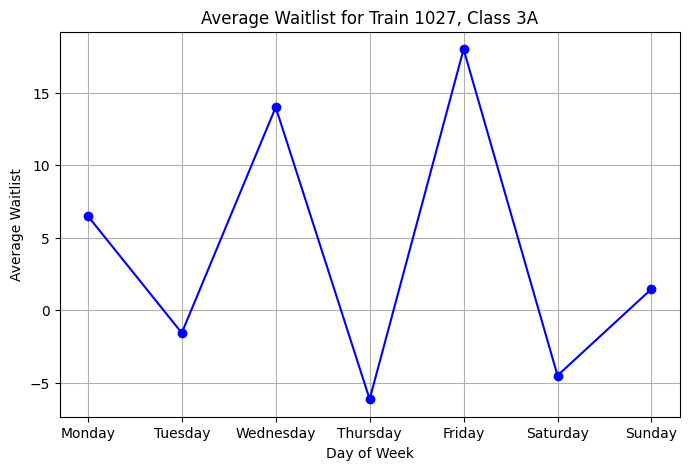

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_3A = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == '3A')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_3A['dayOfWeek'] = pd.Categorical(df_1027_3A['dayOfWeek'], categories=days_order, ordered=True)
df_1027_3A = df_1027_3A.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_3A['dayOfWeek'], df_1027_3A['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class 3A')
plt.grid(True)
plt.show()


C:\Users\Neetu\AppData\Local\Temp\ipykernel_27456\1235399175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_2A_avg['dayOfWeek'] = pd.Categorical(df_1027_2A_avg['dayOfWeek'], categories=days_order, ordered=True)


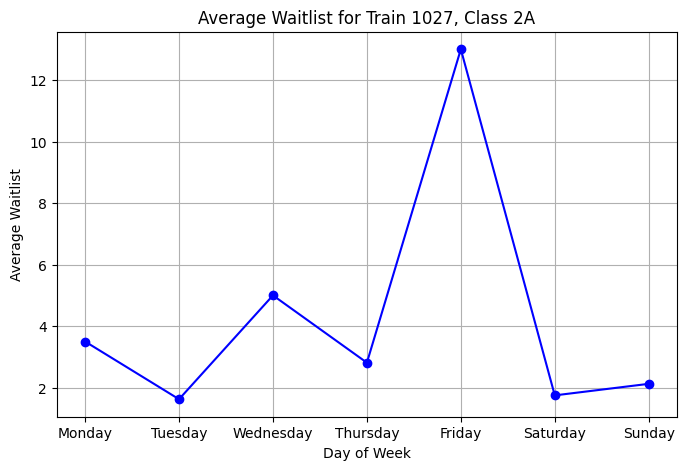

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_2A_avg = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == '2A')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_2A_avg['dayOfWeek'] = pd.Categorical(df_1027_2A_avg['dayOfWeek'], categories=days_order, ordered=True)
df_1027_2A_avg = df_1027_2A_avg.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_2A_avg['dayOfWeek'], df_1027_2A_avg['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class 2A')
plt.grid(True)
plt.show()


C:\Users\Neetu\AppData\Local\Temp\ipykernel_27456\1651065923.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_SL['dayOfWeek'] = pd.Categorical(df_1027_SL['dayOfWeek'], categories=days_order, ordered=True)


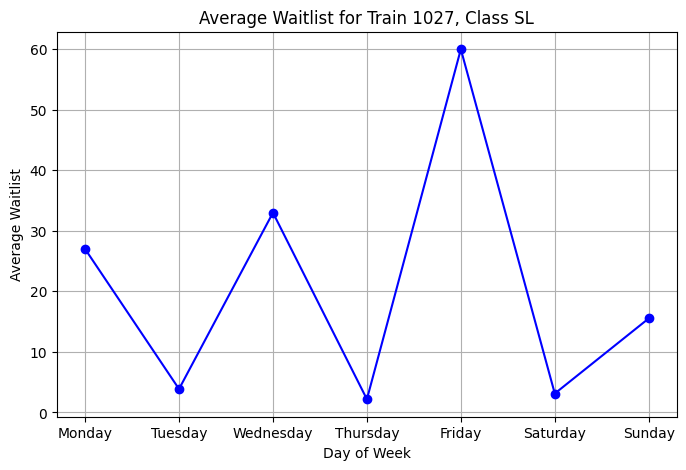

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_SL = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == 'SL')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_SL['dayOfWeek'] = pd.Categorical(df_1027_SL['dayOfWeek'], categories=days_order, ordered=True)
df_1027_SL = df_1027_SL.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_SL['dayOfWeek'], df_1027_SL['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class SL')
plt.grid(True)
plt.show()


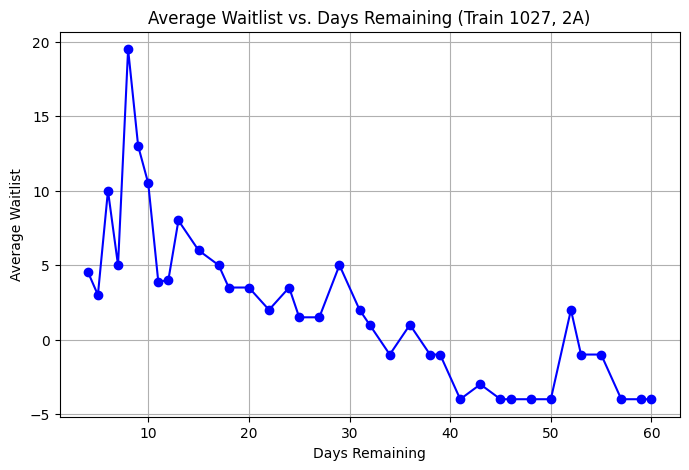

In [7]:


# 1. Filter the DataFrame for Train 1027, Class 2A
df_1027_2A = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == '2A')
]

# 2. Group by daysRemaining and compute the average waitlist
df_1027_2A_grouped = (
    df_1027_2A
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
)

# 3. Sort by daysRemaining so the x-axis is in ascending order
df_1027_2A_grouped = df_1027_2A_grouped.sort_values('daysRemaining')

# 4. Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(
    df_1027_2A_grouped['daysRemaining'],
    df_1027_2A_grouped['waitlist'],
    marker='o',
    linestyle='-',
    color='b'
)
plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, 2A)')
plt.grid(True)
plt.show()



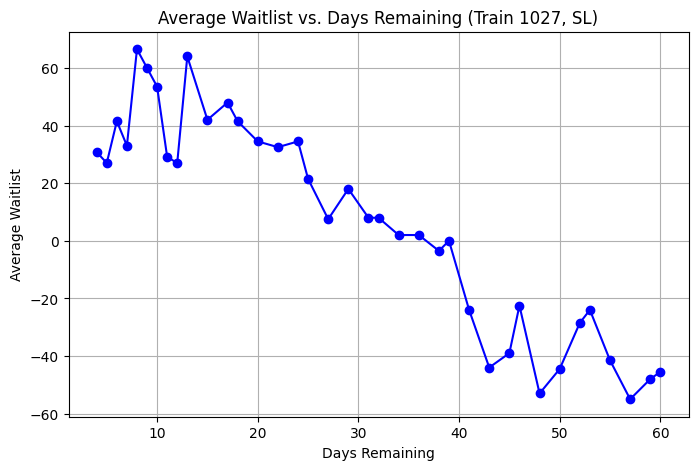

In [41]:


# 1. Filter the DataFrame for Train 1027, Class 2A
df_1027_SL = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == 'SL')
]

# 2. Group by daysRemaining and compute the average waitlist
df_1027_SL_grouped = (
    df_1027_SL
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
)

# 3. Sort by daysRemaining so the x-axis is in ascending order
df_1027_SL_grouped = df_1027_SL_grouped.sort_values('daysRemaining')

# 4. Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(
    df_1027_SL_grouped['daysRemaining'],
    df_1027_SL_grouped['waitlist'],
    marker='o',
    linestyle='-',
    color='b'
)
plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, SL)')
plt.grid(True)
plt.show()



Local maxima (peaks) based on daysRemaining vs. avgWaitlist:
    daysRemaining  avgWaitlist
2               6         10.0
4               8         19.5
9              13          8.0
15             24          3.5
18             29          5.0
22             36          1.0
26             43         -3.0
31             52          2.0

Day-of-week breakdown for each peak dayRemaining:
   daysRemaining dayOfWeek  waitlist
0              6   Tuesday      10.0
1              8  Thursday      19.5
2             13   Tuesday       8.0
3             24  Saturday       3.5
4             29  Thursday       5.0
5             36  Thursday       1.0
6             43  Thursday      -3.0
7             52  Saturday       2.0


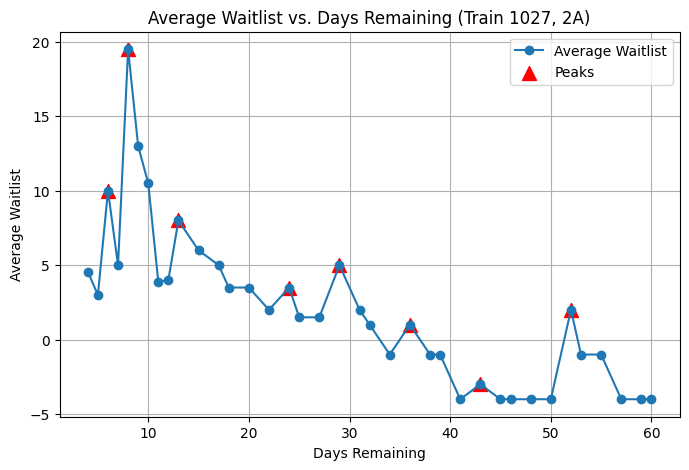

In [28]:

# -------------------------------------------------
# 1. FILTER FOR TRAIN 1027, CLASS 2A
# -------------------------------------------------
df_1027_2A = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == '2A')
].copy()

# -------------------------------------------------
# 2. GROUP BY daysRemaining AND COMPUTE AVERAGE WAITLIST
# -------------------------------------------------
df_avg = (
    df_1027_2A
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
    .rename(columns={'waitlist': 'avgWaitlist'})
    .sort_values('daysRemaining')
)

# -------------------------------------------------
# 3. IDENTIFY LOCAL MAXIMA (PEAKS)
# -------------------------------------------------
# Shift the avgWaitlist column to compare each row with its previous and next
df_avg['prev'] = df_avg['avgWaitlist'].shift(1)
df_avg['next'] = df_avg['avgWaitlist'].shift(-1)

# A local max if avgWaitlist is greater than both neighbors
df_avg['is_peak'] = (
    (df_avg['avgWaitlist'] > df_avg['prev']) &
    (df_avg['avgWaitlist'] > df_avg['next'])
)

# Filter rows that are peaks
peaks = df_avg[df_avg['is_peak']].copy()
peak_days = peaks['daysRemaining'].unique()

print("Local maxima (peaks) based on daysRemaining vs. avgWaitlist:")
print(peaks[['daysRemaining', 'avgWaitlist']])

# -------------------------------------------------
# 4. MAP PEAKS BACK TO ORIGINAL DATA TO SEE dayOfWeek
# -------------------------------------------------
# Filter the original data for these peak days
df_peak_contributors = df_1027_2A[df_1027_2A['daysRemaining'].isin(peak_days)]

# For each peak dayRemaining, see which dayOfWeek values contributed
df_peak_dayofweek = (
    df_peak_contributors
    .groupby(['daysRemaining', 'dayOfWeek'], as_index=False)['waitlist']
    .mean()
    .sort_values(['daysRemaining', 'waitlist'], ascending=[True, False])
)

print("\nDay-of-week breakdown for each peak dayRemaining:")
print(df_peak_dayofweek)

# -------------------------------------------------
# 5. OPTIONAL: PLOT THE avgWaitlist vs. daysRemaining CURVE WITH PEAKS
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(df_avg['daysRemaining'], df_avg['avgWaitlist'], marker='o', linestyle='-', label='Average Waitlist')

# Highlight the peaks in a different color/marker
plt.scatter(peaks['daysRemaining'], peaks['avgWaitlist'], color='red', marker='^', s=100, label='Peaks')

plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, 2A)')
plt.grid(True)
plt.legend()
plt.show()


In [29]:

# Example df_peak_dayofweek structure:
#    daysRemaining  dayOfWeek  waitlist
# 0             6    Tuesday      10.0
# 1             8   Thursday      19.5
# 2            13    Tuesday       8.0
# 3            24  Saturday       3.5                                                                                                                                                                   
# 4            29  Thursday       5.0
# 5            36  Thursday       1.0
# 6            43  Thursday      -3.0
# 7            52  Saturday       2.0

# 1. Group by dayOfWeek and compute mean waitlist among these peak rows
peak_ranking = (
    df_peak_dayofweek
    .groupby('dayOfWeek', as_index=False)['waitlist']
    .mean()
    .rename(columns={'waitlist': 'avgWaitlist'})
    .sort_values('avgWaitlist', ascending=False)
)

# 2. Assign a rank (1 = highest average waitlist)
peak_ranking['rank'] = peak_ranking['avgWaitlist'].rank(method='dense', ascending=False)

print("Day-of-week ranking based on average peak waitlist:")
print(peak_ranking)


Day-of-week ranking based on average peak waitlist:
  dayOfWeek  avgWaitlist  rank
2   Tuesday        9.000   1.0
1  Thursday        5.625   2.0
0  Saturday        2.750   3.0


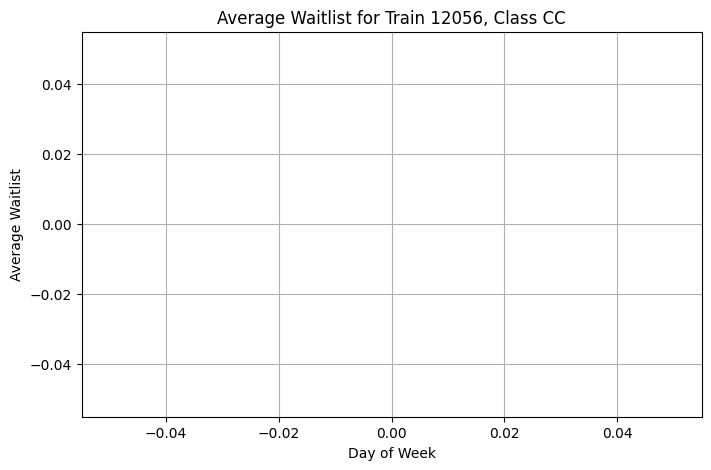

In [30]:


# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_12056_CC = df_train_day_class[(df_train_day_class['trainNumber'] == 12056) &
                                (df_train_day_class['classCode'] == 'CC')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_12056_CC['dayOfWeek'] = pd.Categorical(df_12056_CC['dayOfWeek'], categories=days_order, ordered=True)
df_12056_CC = df_12056_CC.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_12056_CC['dayOfWeek'], df_12056_CC['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 12056, Class CC')
plt.grid(True)
plt.show()


In [31]:
print(df_exploded['waitlist'].min())

-1714.0


In [32]:
print(df_exploded.columns)

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'fuelAmount',
       'totalConcession', 'tatkalFare', 'serviceTax', 'otherCharge',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'fromStnCode', 'toStnCode', 'classCode', 'timeStamp',
       'journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining'],
      dtype='object')


In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Columns of interest
columns_of_interest = ['trainNumber', 'classCode', 'daysRemaining', 'dayOfWeek', 'fromStnCode', 'toStnCode', 'waitlist']

# Select relevant columns (ensure df_exploded exists)
df_subset = df_exploded[columns_of_interest].copy()  # Work on a copy to avoid warnings

# Encode string columns using LabelEncoder
label_encoders = {}
for col in ['classCode', 'fromStnCode', 'toStnCode','dayOfWeek']:
    le = LabelEncoder()
    df_subset[col] = le.fit_transform(df_subset[col].astype(str))  # Convert to string if necessary
    label_encoders[col] = le  # Save encoders for potential reuse

# Compute the correlation matrix
correlation_matrix = df_subset.corr()

# Print the correlation matrix
print(correlation_matrix)


               trainNumber  classCode  daysRemaining  dayOfWeek  fromStnCode  \
trainNumber       1.000000  -0.071821       0.051077  -0.016086     0.048967   
classCode        -0.071821   1.000000      -0.001803  -0.001405     0.040598   
daysRemaining     0.051077  -0.001803       1.000000   0.013515     0.005409   
dayOfWeek        -0.016086  -0.001405       0.013515   1.000000    -0.003877   
fromStnCode       0.048967   0.040598       0.005409  -0.003877     1.000000   
toStnCode         0.137543   0.013883       0.007384  -0.013197     0.057704   
waitlist         -0.038569  -0.196151      -0.110480  -0.004005    -0.035302   

               toStnCode  waitlist  
trainNumber     0.137543 -0.038569  
classCode       0.013883 -0.196151  
daysRemaining   0.007384 -0.110480  
dayOfWeek      -0.013197 -0.004005  
fromStnCode     0.057704 -0.035302  
toStnCode       1.000000 -0.057859  
waitlist       -0.057859  1.000000  


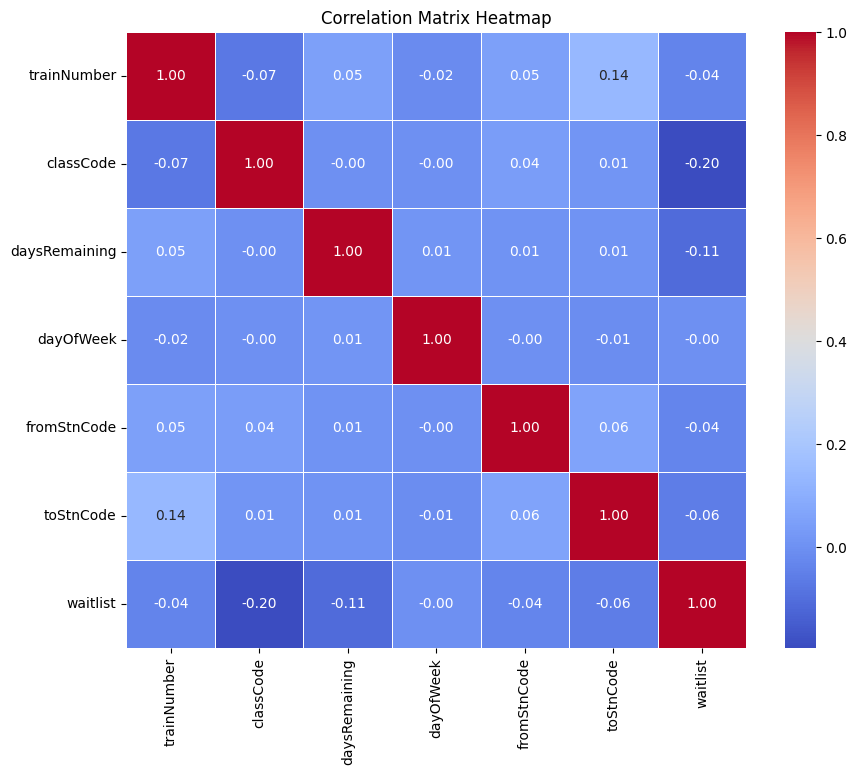

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [35]:
df_exploded.head()

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,...,availability,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,journeyDate,dayOfWeek,waitlist,daysRemaining
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-05,Sunday,10.0,4
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-07,Tuesday,15.0,6
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-09,Thursday,26.0,8
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-11,Saturday,18.0,10
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,10.0,11


In [36]:
df.head()

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,totalFare,availability,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,availability_parsed
0,2350,50,0,0.0,0,0,120.0,0,0,0,2520,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,"[{'journeyDate': 2023-11-05 00:00:00, 'dayOfWe..."
1,2350,50,0,0.0,0,0,120.0,0,0,0,2520,"[{'date': '16-11-2023', 'status': 'PQWL12/WL9'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,"[{'journeyDate': 2023-11-16 00:00:00, 'dayOfWe..."
2,2350,50,0,0.0,0,0,120.0,0,0,0,2520,"[{'date': '26-11-2023', 'status': 'PQWL5/WL2'}...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,"[{'journeyDate': 2023-11-26 00:00:00, 'dayOfWe..."
3,2350,50,0,0.0,0,0,120.0,0,0,0,2520,"[{'date': '7-12-2023', 'status': 'PQWL1/WL1'},...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,"[{'journeyDate': 2023-12-07 00:00:00, 'dayOfWe..."
4,2350,50,0,0.0,0,0,120.0,0,0,0,2520,"[{'date': '17-12-2023', 'status': 'AVAILABLE-0...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,"[{'journeyDate': 2023-12-17 00:00:00, 'dayOfWe..."


In [37]:
df['availability'][100]

"[{'date': '7-11-2023', 'status': 'AVAILABLE-0423'}, {'date': '14-11-2023', 'status': 'AVAILABLE-0379'}, {'date': '21-11-2023', 'status': 'AVAILABLE-0141'}, {'date': '28-11-2023', 'status': 'AVAILABLE-0503'}, {'date': '5-12-2023', 'status': 'AVAILABLE-0576'}, {'date': '12-12-2023', 'status': 'AVAILABLE-0579'}]"

In [38]:
df['timeStamp'].unique()

<DatetimeArray>
['2023-10-31 19:25:08.643266', '2023-10-31 19:26:14.630191',
 '2023-10-31 19:26:55.084767', '2023-10-31 19:28:04.994790',
 '2023-10-31 19:28:43.853091', '2023-10-31 19:29:22.219708',
 '2023-10-31 19:30:09.339394', '2023-10-31 19:30:58.748249',
 '2023-10-31 19:31:51.296005', '2023-10-31 19:34:42.417645',
 ...
 '2023-10-31 19:58:03.036610', '2023-10-31 20:00:49.109998',
 '2023-10-31 20:11:10.058549', '2023-10-31 20:16:03.115637',
 '2023-10-31 20:25:51.965037', '2023-10-31 20:32:29.835515',
 '2023-10-31 20:35:20.533861', '2023-10-31 20:36:01.059423',
 '2023-10-31 20:42:45.776943', '2023-10-31 20:43:44.098136']
Length: 125, dtype: datetime64[ns]

In [39]:
df_1027_SL


,trainNumber,dayOfWeek,classCode,waitlist
5,1027,Monday,SL,27.00000
17,1027,Tuesday,SL,3.87500
20,1027,Wednesday,SL,33.00000
14,1027,Thursday,SL,2.18750
2,1027,Friday,SL,60.00000
8,1027,Saturday,SL,3.12500
11,1027,Sunday,SL,15.53125


In [40]:
df_1027_2A

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,...,availability,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,journeyDate,dayOfWeek,waitlist,daysRemaining
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-05,Sunday,10.0,4
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-07,Tuesday,15.0,6
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-09,Thursday,26.0,8
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-11,Saturday,18.0,10
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,10.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,1497,50,0,0.0,0,0,78.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'RLWL5/WL4'},...",1027,TKMG,BSB,2A,2023-10-31 19:25:08.643266,2023-11-06,Monday,3.0,5
54,1497,50,0,0.0,0,0,78.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'RLWL5/WL4'},...",1027,TKMG,BSB,2A,2023-10-31 19:25:08.643266,2023-11-08,Wednesday,5.0,7
54,1497,50,0,0.0,0,0,78.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'RLWL5/WL4'},...",1027,TKMG,BSB,2A,2023-10-31 19:25:08.643266,2023-11-10,Friday,13.0,9
54,1497,50,0,0.0,0,0,78.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'RLWL5/WL4'},...",1027,TKMG,BSB,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,3.0,11
